## Use the ProcessWordle Module

In [1]:
from importlib import reload
from ProcessWordle import ScrabblePoints, ParseWordle
import censoring

In [2]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frames(sp.words_df)
pw.write_final_df()

## Import Modules for PYMC

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import censoring

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Load Data

In [4]:
# load data
df = pd.read_csv(censoring.wordle_output)

## One more layer of processing

It turns out that if someone does not participate, then they will have a lower score (lower rate of fails) then someone who did particpate.
Thus, the contest should only be around puzzles which have equal contributions. 

In [5]:
# limit to the puzzle in which we last have words
df2 = df[ (df['PuzzleNum'] < 482) & 
         (df['PuzzleNum'] != 421) & 
         (df['Difficulty'] != 'Undefined')
        ].copy()

## This section should move to the App, as a filter
# then I can select all games which have the same 4 players, the same 5 players, etc. 
# and then the model should run on the full data set

# how many players participated, per puzzle? 
# puzzle_count_df = df2[['Name','PuzzleNum']].groupby(['PuzzleNum']).agg('count').reset_index()
# list of puzzles which have 6 people, even
# list_of_puzzles = puzzle_count_df[ puzzle_count_df['Name'] == 6 ]['PuzzleNum'].tolist()
# over-write previous dataframe 
# df2 = df2[ df2['PuzzleNum'].isin(list_of_puzzles)].copy()

### Reshape data to move players/difficulty to columns

In [21]:
alias_list = [ censoring.name_alias[i] for i in [*censoring.name_alias]]

In [23]:
df4 = pd.concat(
    [
        pd.concat(
            [
                df2[['PuzzleNum','Fails', 'FinalScore','ScrabblePoints', 'Difficulty']], pd.get_dummies(df2['Name'])
            ], 
            axis=1, 
            ignore_index=True
        ),
        pd.get_dummies(df2['Difficulty'])
    ],
    axis=1,
    ignore_index=True
)

df4 = df4.rename(columns={
    0 : 'PuzzleNum', 
    1 : 'Fails', 
    2 : 'FinalScore',
    3 : 'ScrabblePoints', 
    4 : 'Difficulty', 
    5 : 'Da.M', 
    6 : 'Ka.W', 
    7 : 'St.S', 
    8 : 'Ca.W', 
    9 : 'Da.S', 
    10 : 'Ka.S',
    11 : 'Su.S',
    12 : 'Ja.F',
    13 : 'Easy', 
    14 : 'Hard'
})

df4 = df4.reset_index()

In [24]:
df4.head()

,index,PuzzleNum,Fails,FinalScore,ScrabblePoints,Difficulty,Da.M,Ka.W,St.S,Ca.W,Da.S,Ka.S,Su.S,Ja.F,Easy,Hard
0,0,195,5,6,11.0,Easy,0,1,0,0,0,0,0,0,1,0
1,1,195,5,6,11.0,Easy,0,0,0,0,0,1,0,0,1,0
2,2,195,2,3,11.0,Easy,0,0,0,0,0,0,1,0,1,0
3,3,195,4,5,11.0,Easy,1,0,0,0,0,0,0,0,1,0
4,4,196,4,5,7.0,Easy,0,0,0,0,0,0,1,0,1,0


## Model 2
The 'players' are treated as one-hot encoded columns. This allows me to make predicions by using pm.set_data(). But is it worth it? 

Should I be adding a 'puzzle' dimension, here? 
Need to double-check which variables I am pooling / not-pooling. From a conceptual standpoint, each player should be independent, but difficulty should not be independent?

In [28]:
with pm.Model(
    coords={
        "obs": df4.index.values, 
        "Player": alias_list[0:6],
        "Difficulty":['Easy','Hard']
    }
) as BB2:
    
    # using pm.data
    y = pm.MutableData("y", df4['Fails'].to_numpy())
    x = pm.MutableData("x", df4[alias_list[0:6] + ['Easy','Hard']].to_numpy())
    
    # Names - Hyper Priors
    HPNamesασ = pm.Normal("HPNamesασ", mu=3, sigma=1)
    HPNamesβσ = pm.Normal("HPNamesβσ", mu=3, sigma=1)
    
    # Difficulty - Hyper Priors  
    HPDiffασ = pm.Normal("HPDiffασ", mu=3, sigma=1)
    HPDiffβσ = pm.Normal("HPDiffβσ", mu=3, sigma=1)
    
    # Names
    Namesα = pm.HalfNormal("Namesα", sigma=HPNamesασ, dims="Player")
    Namesβ = pm.HalfNormal("Namesβ", sigma=HPNamesβσ, dims="Player")

    # Difficulty
    Diffα = pm.HalfNormal("Diffα", sigma=HPDiffασ, dims="Difficulty")
    Diffβ = pm.HalfNormal("Diffβ", sigma=HPDiffβσ, dims="Difficulty")

    # Error
    ϵα = pm.HalfNormal("ϵα", sigma=1)
    ϵβ = pm.HalfNormal("ϵβ", sigma=1)
    
    # likelihood
    θα = pm.Deterministic("θα", pm.math.dot(x[:,0:6], Namesα) + pm.math.dot(x[:, 6:], Diffα) + ϵα)
    θβ = pm.Deterministic("θβ", pm.math.dot(x[:,0:6], Namesβ) + pm.math.dot(x[:, 6:], Diffβ) + ϵβ)

    # response
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=θα, 
        beta=θβ, 
        observed=y
    )

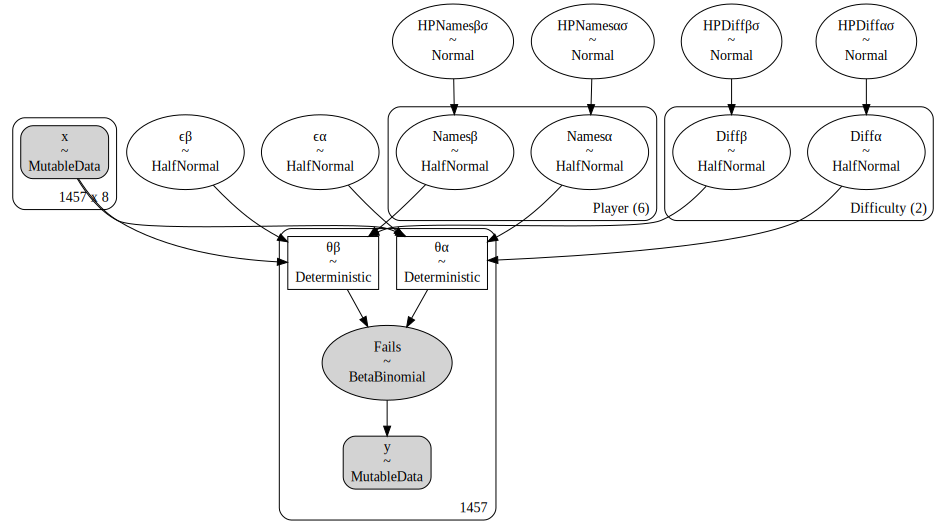

In [29]:
pm.model_to_graphviz(BB2)

In [30]:
with BB2:
    trace2 = pm.sample(
        draws=1000,
        tune=2000,
        # start={
        #     'Namesβ': np.array([1., 1., 1., 1., 1., 1.]), 
        #     'Namesα': np.array([1., 1., 1., 1., 1., 1.]), 
        # }, 
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HPNamesασ, HPNamesβσ, HPDiffασ, HPDiffβσ, Namesα, Namesβ, Diffα, Diffβ, ϵα, ϵβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 302 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


## Display Summary
The standard deviations of these estimates are enormous! Should the 'names' variables be something else, like a normal or something? 

In [31]:
az.summary(trace2, var_names=["HPNamesασ","HPNamesβσ","HPDiffβσ", "HPDiffασ", "Namesα", "Namesβ", "Diffα", "Diffβ", "ϵα", "ϵβ"])
# m = az.summary(trace2, var_names=["HPNamesασ","HPNamesβσ","HPDiffβσ", "HPDiffασ", "Namesα", "Namesβ", "Diffα", "Diffβ", "ϵα", "ϵβ"])
# m.to_csv(path_or_buf=r'C:\Users\HG749BX\OneDrive - EY\Documents\Python\wordle-analysis\model_output.csv', index=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
HPNamesασ,4.503,0.763,3.099,5.943,0.015,0.010,2682.0,2747.0,1.0
HPNamesβσ,2.923,0.928,1.071,4.619,0.018,0.013,2488.0,2430.0,1.0
HPDiffβσ,5.352,0.704,4.048,6.693,0.012,0.008,3726.0,2975.0,1.0
HPDiffασ,5.163,0.737,3.760,6.507,0.013,0.009,3429.0,3366.0,1.0
Namesα[Da.M],5.140,2.088,1.491,9.097,0.042,0.030,2302.0,2372.0,1.0
Namesα[Ka.W],5.625,2.202,1.586,9.578,0.050,0.035,1798.0,1976.0,1.0
Namesα[St.S],7.791,2.342,3.422,12.098,0.045,0.032,2645.0,2577.0,1.0
Namesα[Ca.W],3.630,2.663,0.013,8.287,0.043,0.030,2914.0,1968.0,1.0
Namesα[Da.S],6.766,2.226,2.723,10.831,0.046,0.033,2207.0,2584.0,1.0
Namesα[Ka.S],6.680,2.335,2.574,11.112,0.049,0.035,2043.0,2291.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

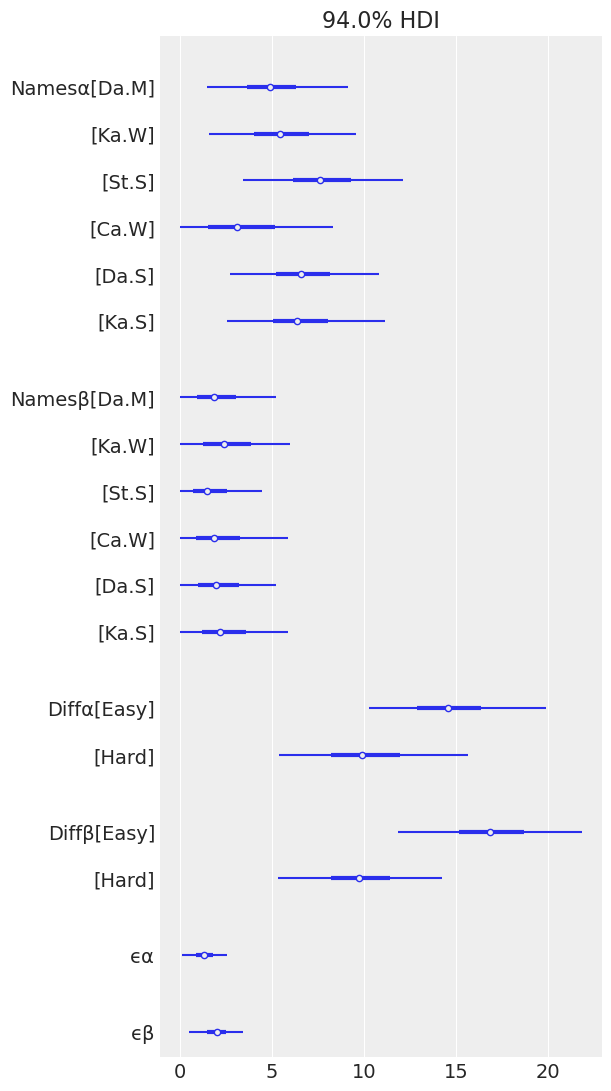

In [32]:
# az.plot_forest(trace2, var_names=["HPNamesασ","HPNamesβσ","HPDiffβσ", "HPDiffασ"], combined=True)
az.plot_forest(trace2, var_names=["Namesα", "Namesβ", "Diffα", "Diffβ", "ϵα", "ϵβ"], combined=True)

## Posterior Predictive

In [33]:
with BB2:
    ppc_data_trace2 = pm.sample_posterior_predictive(trace2, extend_inferencedata=True)

<AxesSubplot:xlabel='Fails / Fails'>

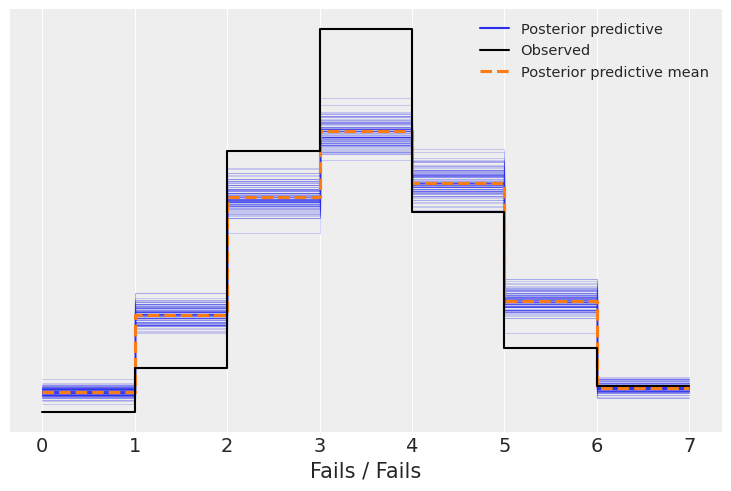

In [34]:
az.plot_ppc(ppc_data_trace2, num_pp_samples=100)

### Permute with set data
Here I get the average fails for each person, for each difficulty. 
This is straightforward to do using the data container and the 'set_data()' method. 

In [36]:
test_raw = pd.DataFrame({
    'Players': alias_list[0:6] + alias_list[0:6],
    'Difficulty': ['Easy','Easy', 'Easy','Easy','Easy','Easy','Hard','Hard','Hard','Hard','Hard','Hard']
})

# convert to design matrix
test = pd.get_dummies(test_raw)
# change names of columns
keys = test.columns
values = alias_list[0:6] + ['Easy', 'Hard']
col_mapper= dict(zip(keys, values))
test = test.rename(columns=col_mapper)

In [37]:
with BB2:
    pm.set_data({'x': test.to_numpy()})
    y_test = pm.sample_posterior_predictive(trace2)
    
test_raw['prediction'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw')).to_numpy()

In [39]:
test_raw.to_csv(r'C:\Users\HG749BX\OneDrive - EY\Documents\Python\wordle-app\predictions.csv', index=False)

## Create BetaBinomial Distributions based on summary parameters
The above method gives me the _overall average response_ for each condition (player, difficulty). 
But what if I wanted the density, the proportion of expected fails for each player, for each difficulty? 
Here I explicitly attempt to simulate that using the mean parameter derived from the trace. 

In [40]:
n_a = az.summary(trace2, var_names="Namesα")
n_b = az.summary(trace2, var_names="Namesβ")
d_a = az.summary(trace2, var_names="Diffα")
d_b = az.summary(trace2, var_names="Diffβ")
e_a = az.summary(trace2, var_names="ϵα")
e_b = az.summary(trace2, var_names="ϵβ")

In [41]:
x_a = []
x_b = []

for j in [0, 1]: 
    for i in [0, 1, 2, 3, 4, 5]: 

        temp_a = n_a['mean'][i] + d_a['mean'][j] + e_a['mean'][0]
        temp_b = n_b['mean'][i] + d_b['mean'][j] + e_b['mean'][0]
        
        x_a.append(temp_a)
        x_b.append(temp_b)

In [42]:
x_a

[21.211,
 21.695999999999998,
 23.862000000000002,
 19.701,
 22.837000000000003,
 22.750999999999998,
 16.649,
 17.134,
 19.300000000000004,
 15.139000000000001,
 18.275,
 18.189]

In [43]:
easy_final=[]
hard_final=[]
with pm.Model() as m:
    for k in [0,1,2,3,4,5]:
        easy = pm.BetaBinomial("easy"+str(k),
                                n=6, 
                                alpha = x_a[k],
                                beta = x_b[k])
        t = pm.draw(easy, draws = 500)
        easy_final.append(t)
            
with pm.Model() as n:
    for k in [6, 7, 8, 9, 10, 11]:
        hard = pm.BetaBinomial("hard"+str(k),
                                n=6, 
                                alpha = x_a[k],
                                beta = x_b[k])
        t = pm.draw(hard, draws = 500)
        hard_final.append(t)

In [44]:
easy = np.reshape(easy_final, (500, 6))
hard = np.reshape(hard_final, (500, 6))

stacked = np.vstack((easy, hard))

density_df = pd.DataFrame(stacked, columns=alias_list[0:6])

In [45]:
a = ['Easy' for i in np.arange(0,500)]
b = ['Hard' for j in np.arange(500,1000)]
density_df['Difficulty'] = a + b

template_df = pd.DataFrame({'Difficulty': ['Easy' for i in np.arange(0,7) ] + ['Hard' for i in np.arange(0,7) ],
                            'Fails': [ i for i in np.arange(0,7) ] + [ i for i in np.arange(0,7) ]})

template_df.head()

,Difficulty,Fails
0,Easy,0
1,Easy,1
2,Easy,2
3,Easy,3
4,Easy,4


In [46]:
# loop
for col in alias_list[0:6]:
    x = pd.DataFrame(density_df[['Difficulty', col]].groupby('Difficulty').value_counts(normalize=True, sort=False)).reset_index().rename(columns={ col : 'Fails', 0: col})
    # join each players density to the template, side by side
    template_df = template_df.merge(x, how='left', on = ['Difficulty', 'Fails'])
    
# melt the players kdensities ( each column ) so that data goes from wide to long
template_df = template_df.melt(id_vars=['Difficulty','Fails'], var_name='Name',value_name='Density')

In [48]:
# write to csv
template_df.to_csv(r'C:\Users\HG749BX\OneDrive - EY\Documents\Python\wordle-app\BetaBinomialOut.csv', index=False)